# Setup; importing and ginga stuff

In [8]:
%matplotlib notebook

import matplotlib.pyplot as plt

#import statements
import vis_calculations as viscalc
import vis_plotting as visplot
import vis_coordinates as viscoords

import numpy as np
from importlib import reload  #for debugging purposes


In [2]:
#ginga setup stuff

from ginga.version import version
version
from ginga.web.pgw import ipg
# Set this to True if you have a non-buggy python OpenCv bindings--it greatly speeds up some operations
use_opencv = True
server = ipg.make_server(host='localhost', port=9914, use_opencv=use_opencv)
server.start(no_ioloop=True)

#create a viewer window and open
v1 = server.get_viewer('v1')
v1.open()

# An embedded window for the image

In [3]:
#embed the viewer window
v1.embed(height=650)

# Set Parameters

IN the following section, set the parameters used by the centroiding
algorithm, as well as the scale between image pixels and mm at the mask

In [70]:
#set parameters for centroiding

#basic parameters - threshold probably needs to be tuned it should be 
#above the background but below the lowest peak value. 
fwhm=3        
boxsize=9
thresh=2500

#shape parameters for centroiding. If the points are not circular,
#rl and rh may need to be changed; -1, 1 are the values for a circular
#psf. sl and sh should probably not need to be changed

rl=-2.5
rh=1.3
sl=0.05
sh=0.5

#scale for the instrument setup
inst_scale=5006./340

#rotation of the mask wrt the image

rotated=1

#prefix is for output plots, filename is the input plot
prefix="test"
filename="MCST_010_001.fits"


# Load an image

The following section loads the image into the ginga plugin, and 
into an image array. This should be changed to allow querying the MCS
database.


In [9]:
#load a file into viewer (replace with database stuff)
v1.load(filename)

#read the image from file from file
image=visplot.getImage(filename)


# Get Region of Interest

For the first night, we won't know the position of the mask on the image. To get an approximation, pan and zoom to the appropriate region 
in the ginga viewer above, and execute the followin section to read the 
region shown.

In [12]:


## #get region panned to (needed for later analysis)

regionCoords=v1.get_pan_rect()
print(regionCoords)
region=[regionCoords[0,0],regionCoords[1,0],regionCoords[0,1],regionCoords[3,1]]

print(region)

[[ 5.0000e-01  7.3685e+03]
 [ 8.9595e+03  7.3685e+03]
 [ 8.9595e+03 -1.5905e+03]
 [ 5.0000e-01 -1.5905e+03]]
[0.5, 8959.5, 7368.5, -1590.5]


# Do the centroiding

The following section runs the centroiding algorithm, and plots the result. 

<IPython.core.display.Javascript object>


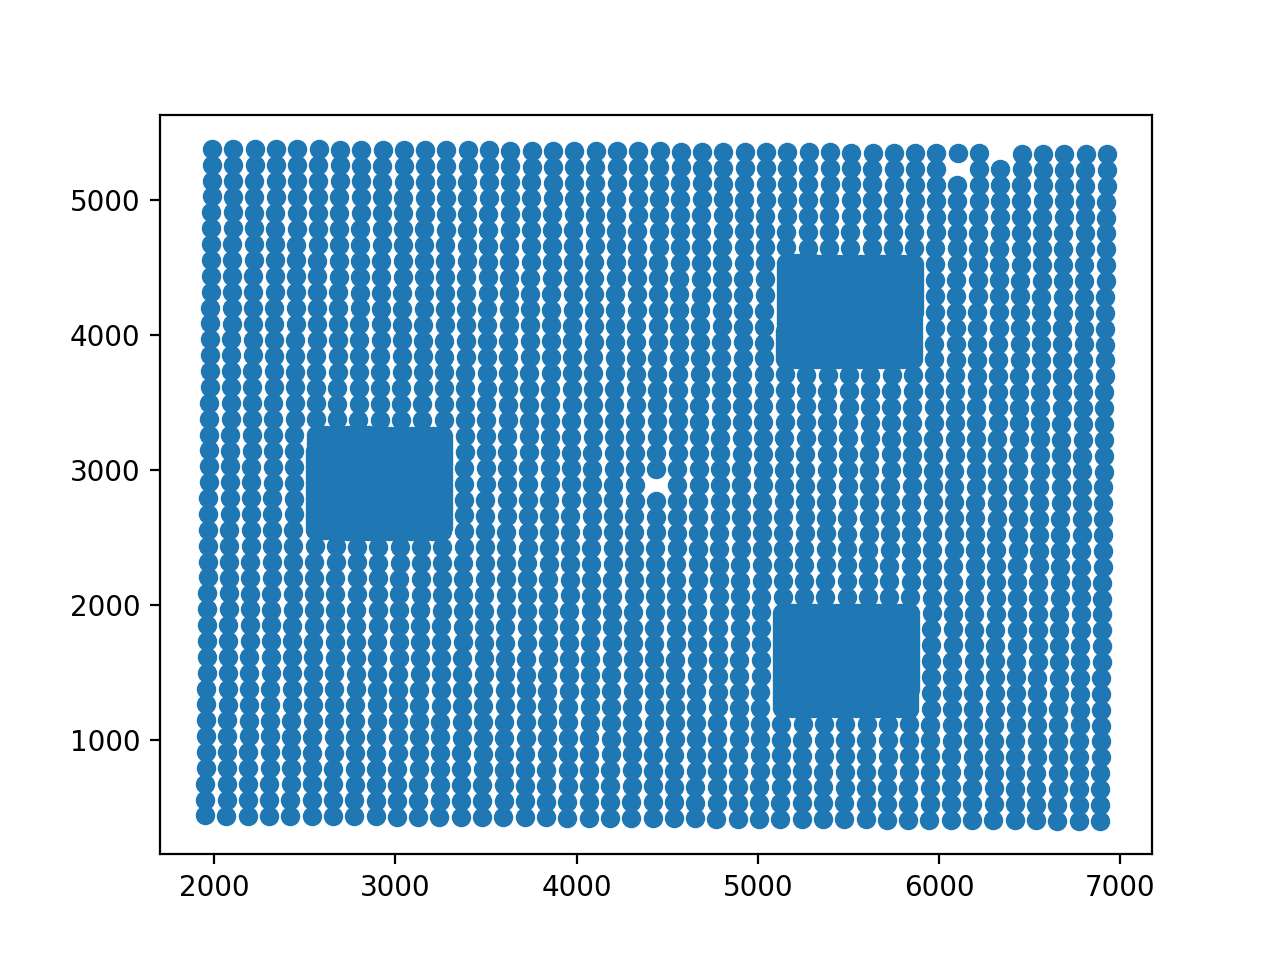

In [12]:


#do the centroiding.
reload(viscalc)

#you may need to do this a couple of times, to tune parameters

x,y,fx,fy,back,peak=viscalc.getCentroids(image,fwhm,boxsize,thresh,rl,rh,sl,sh)

visplot.checkCentroids(x,y,0,prefix)


# Mask calculations

The next section calculates the approximate position of the mask region, and the angle of rotation. Change the rotated parameter if 
the mask and image are rotated 90 degrees wrt each other (this is a 
difference between data taken in Taipei and Hilo. 

It then scales the centroids to mm coordinates, and applies a rotation to the mask if needed. The image spots and mask spots are then matched.



4440.49448507 2893.64570992 1.56175110667 14.6930902834


<IPython.core.display.Javascript object>


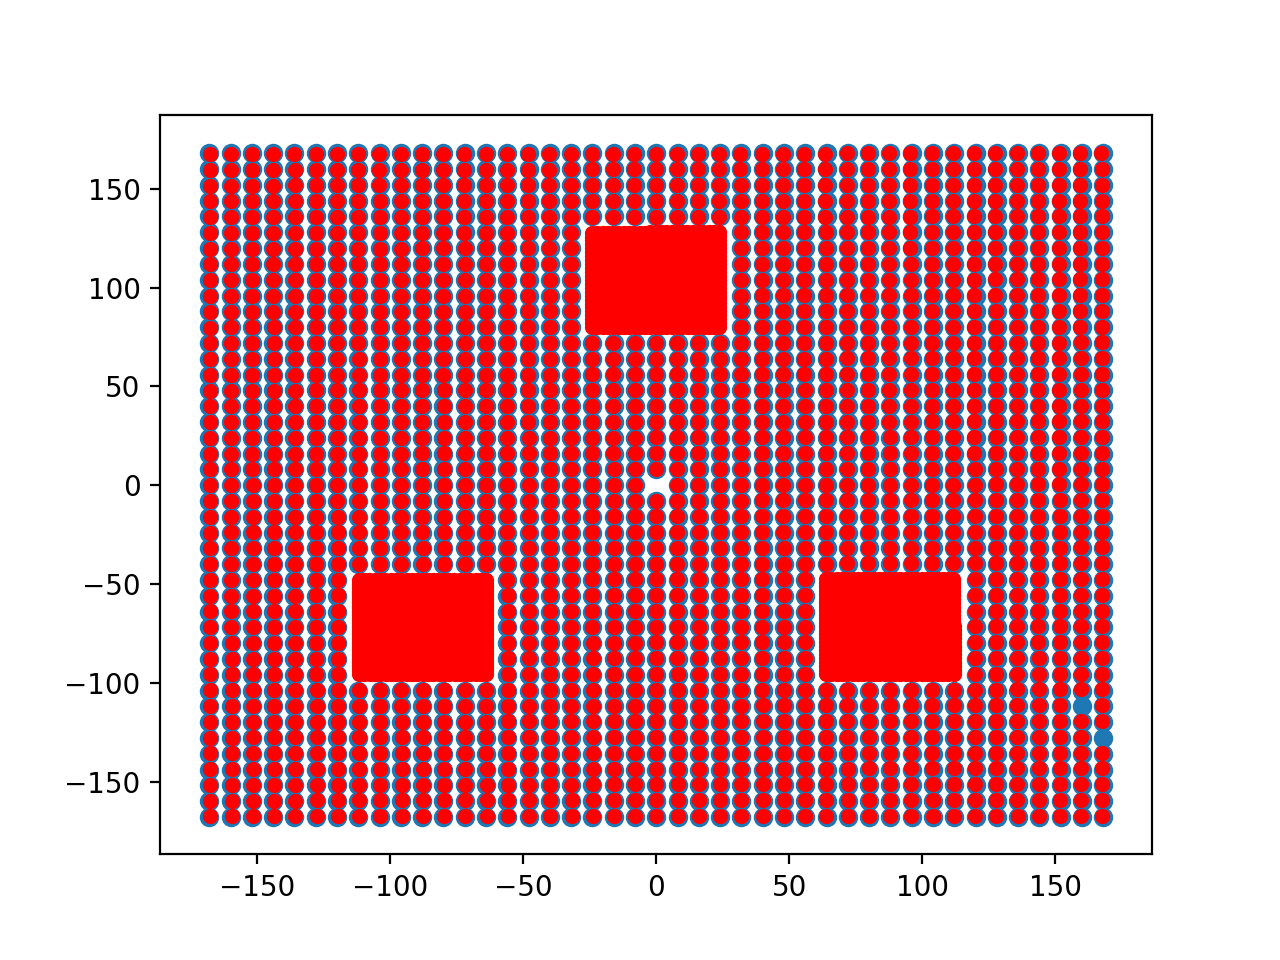

<IPython.core.display.Javascript object>


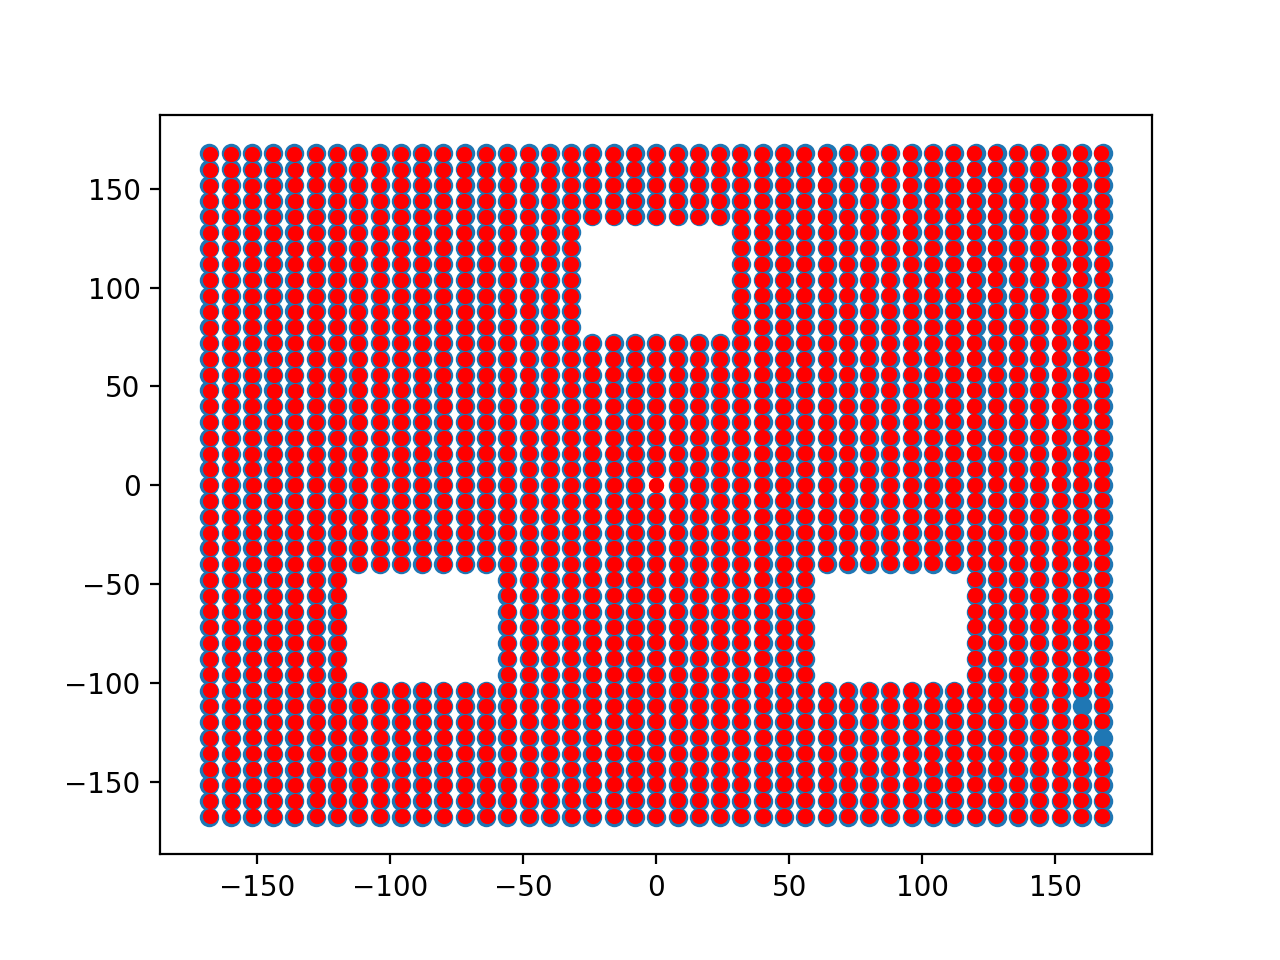

In [73]:

reload(viscoords)
xm,ym,xd,yd,angle,scale=viscoords.getApproximateTransform(x,y,1)
includeClose=0
print(xd,yd,angle,scale)
xx,yy=viscoords.maskinMM(includeClose)
xx=xx-168
yy=yy-168
xa,ya=viscoords.transformMask(x,y,-xd,-yd,0,1)
xc,yc=viscoords.transformMask(xa,ya,0,0,-angle,1/inst_scale)
#xc,yc=viscoords.transformMask(x,y,-xd,-yd,-angle,1/scale)
xs,ys,fxs,fys,peaks=viscoords.matchPoints(xc,yc,xx,yy,fx,fy,peak)

visplot.checkMatched(xc,yc,xx,yy,prefix)
visplot.checkMatched(xs,ys,xx,yy,prefix)




# Image Quality Plots

Plots of FWHM values, peak values, and a rough calculation of total flux.  Set plotrange to the range you want for the colour bar (2 element numpy array); the default is min and max. 


(1701,) (1701,) (1701,)


<IPython.core.display.Javascript object>


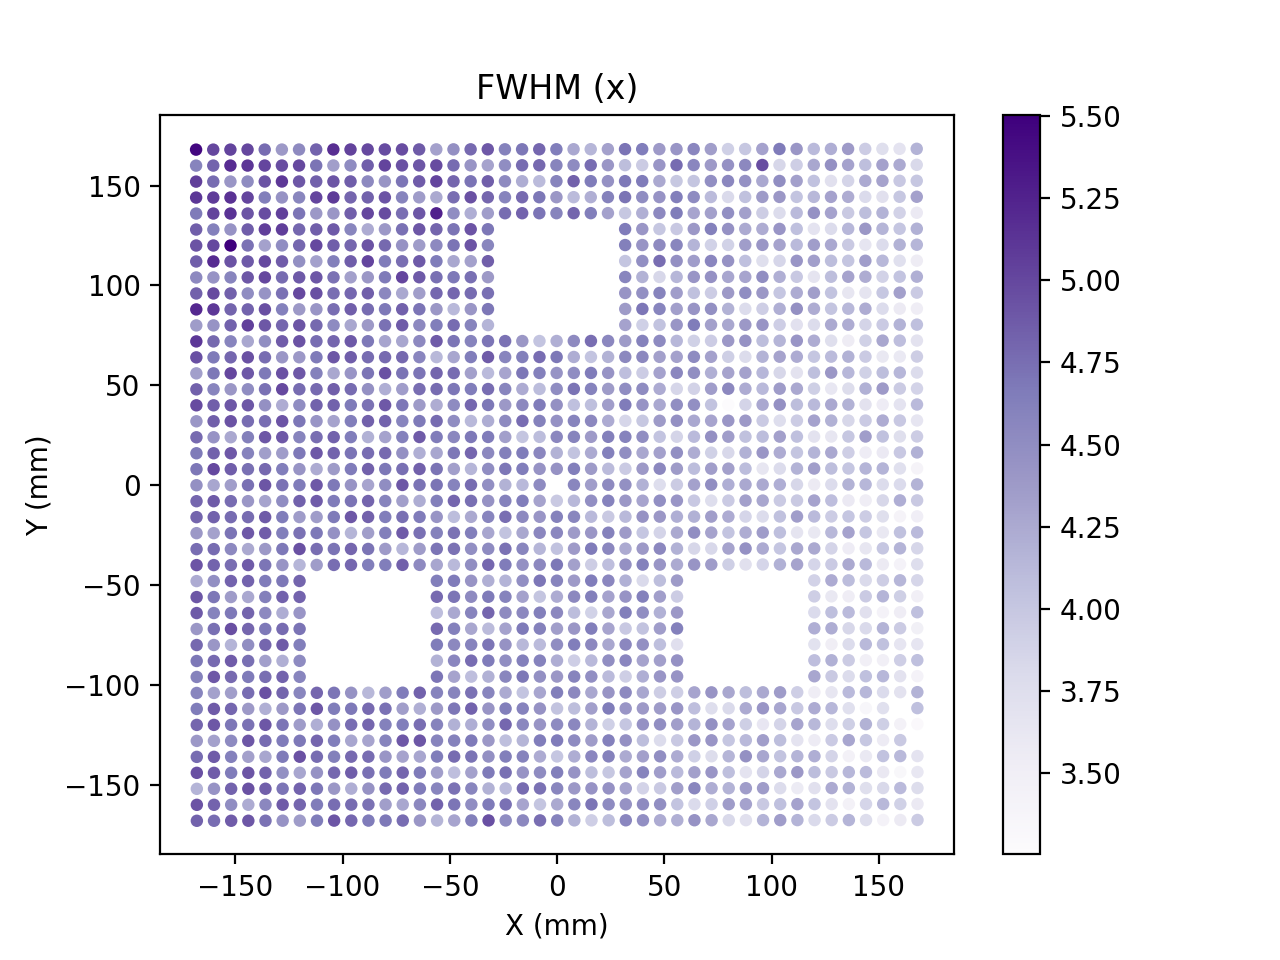

<IPython.core.display.Javascript object>


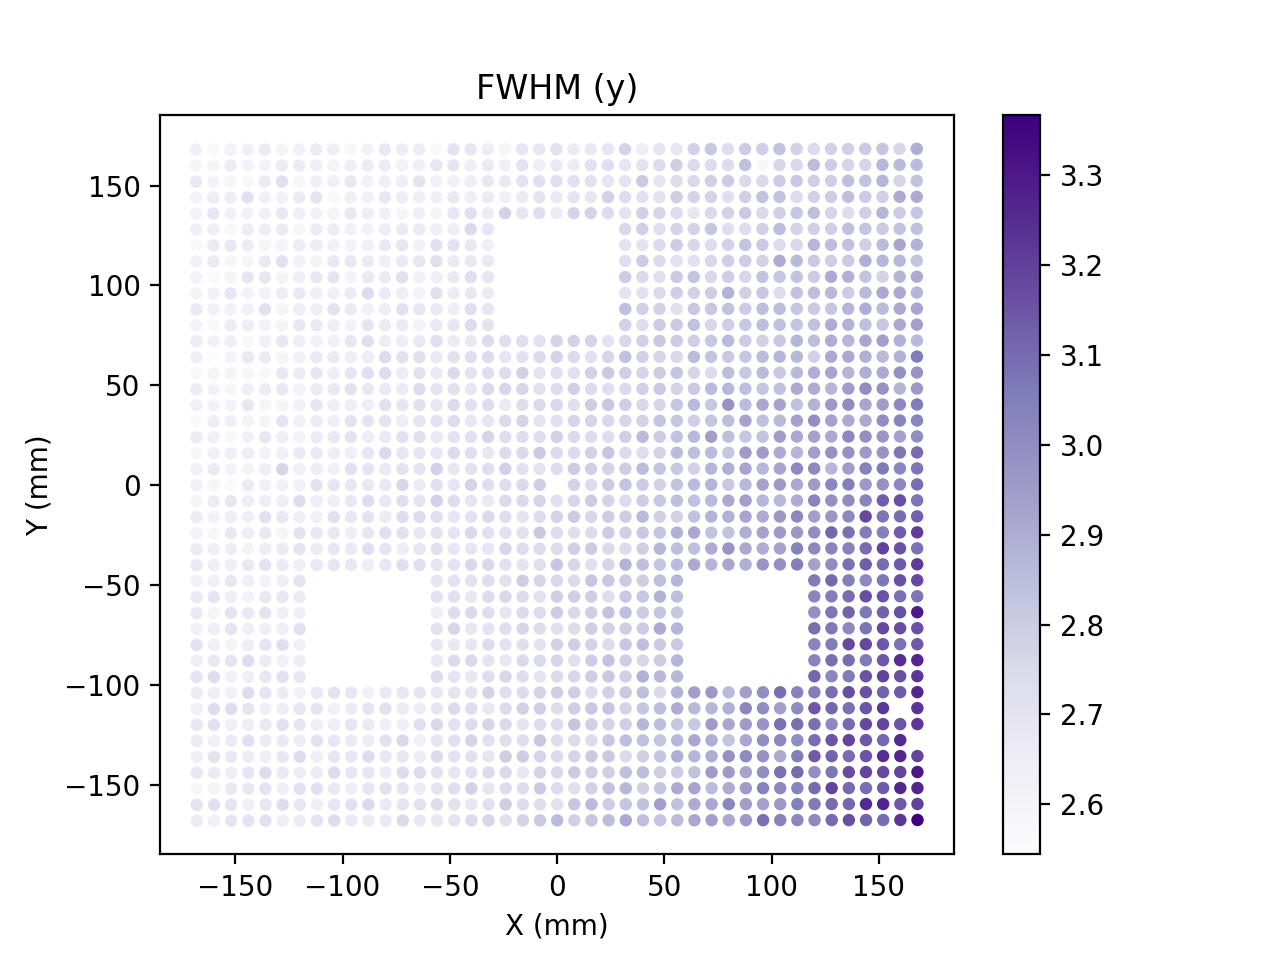

/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


<IPython.core.display.Javascript object>


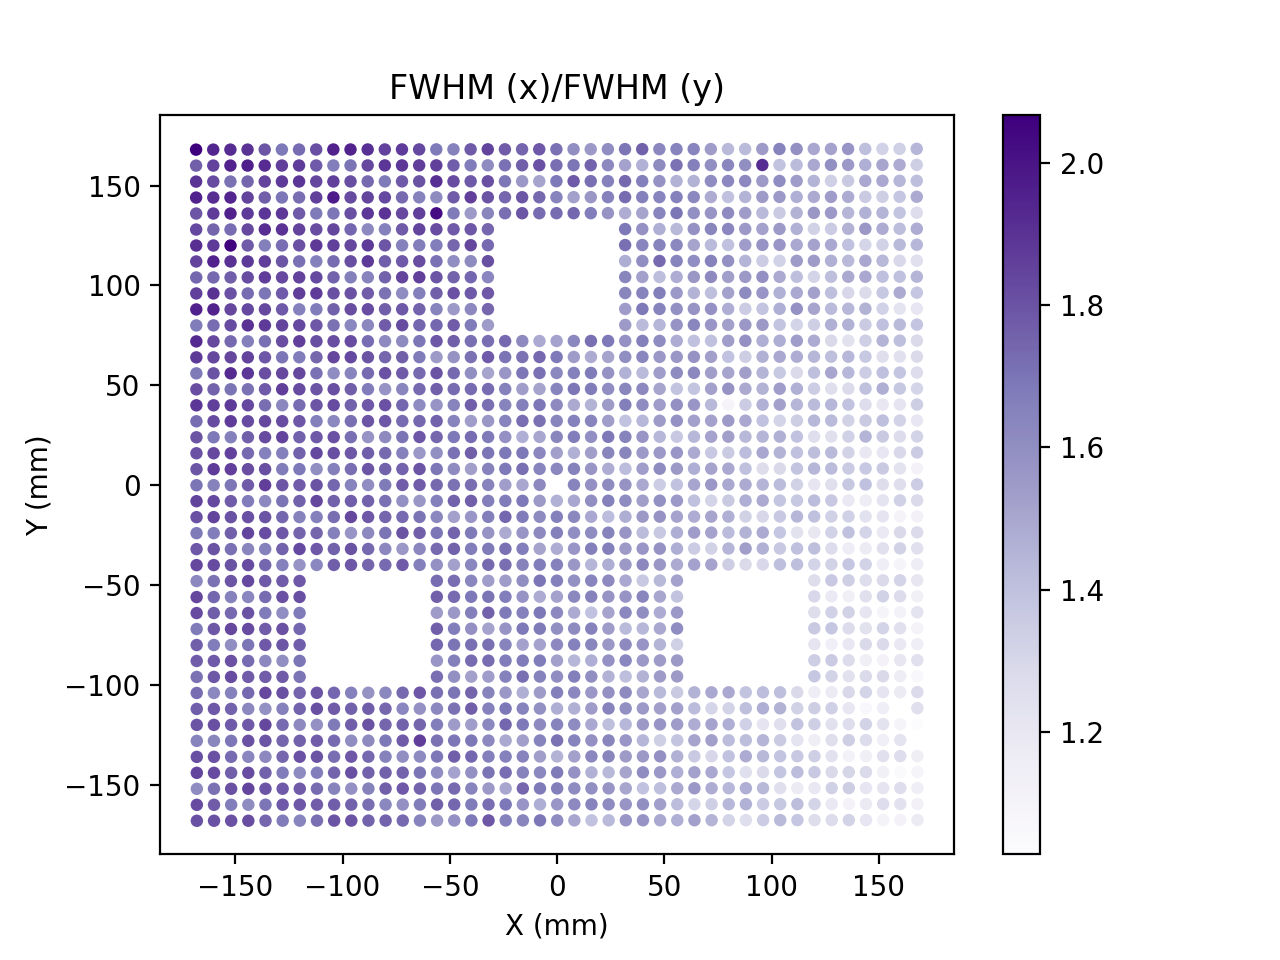

In [66]:
reload(visplot)
limit=10
plotrange=None
print(xx.shape,yy.shape,fxs.shape)
visplot.plotVal(xs,ys,fxs,limit,plotrange,"FWHM (x)",prefix,"_fwhmx",'mm')
visplot.plotVal(xs,ys,fys,limit,plotrange,"FWHM (y)",prefix,"_fwhmy",'mm')
visplot.plotVal(xs,ys,fxs/fys,0,plotrange,"FWHM (x)/FWHM (y)",prefix,"_fwhmxy",'mm')


# Distortion Plots

Calculations and plots for distortion of a single field. The results are plotted in three forms; quiver, colour map in mm units, colour map in units of % of the field size. 


sx= 1.00226987669  sy= 1.00226987669


<IPython.core.display.Javascript object>


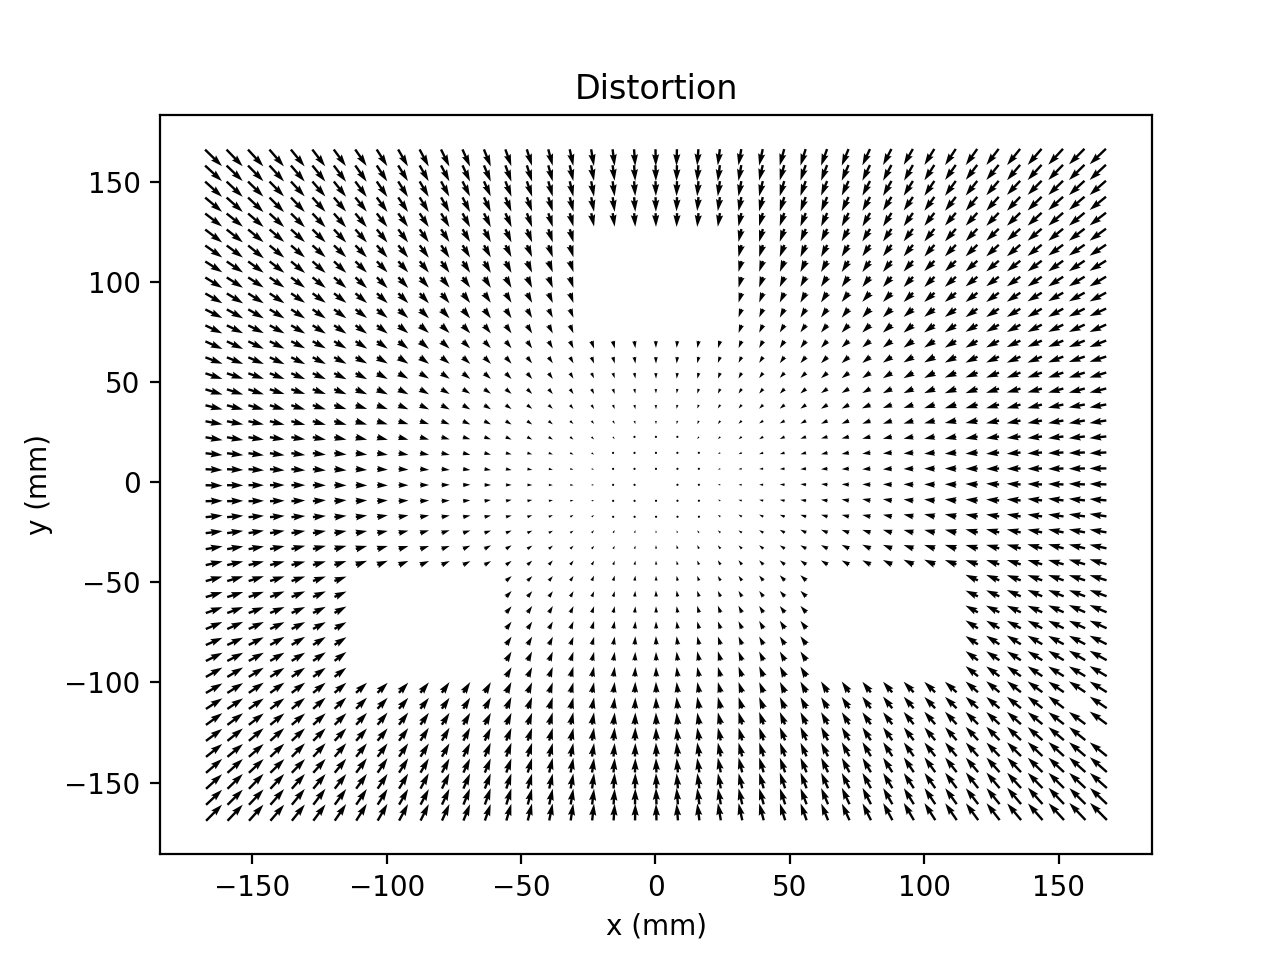

<IPython.core.display.Javascript object>


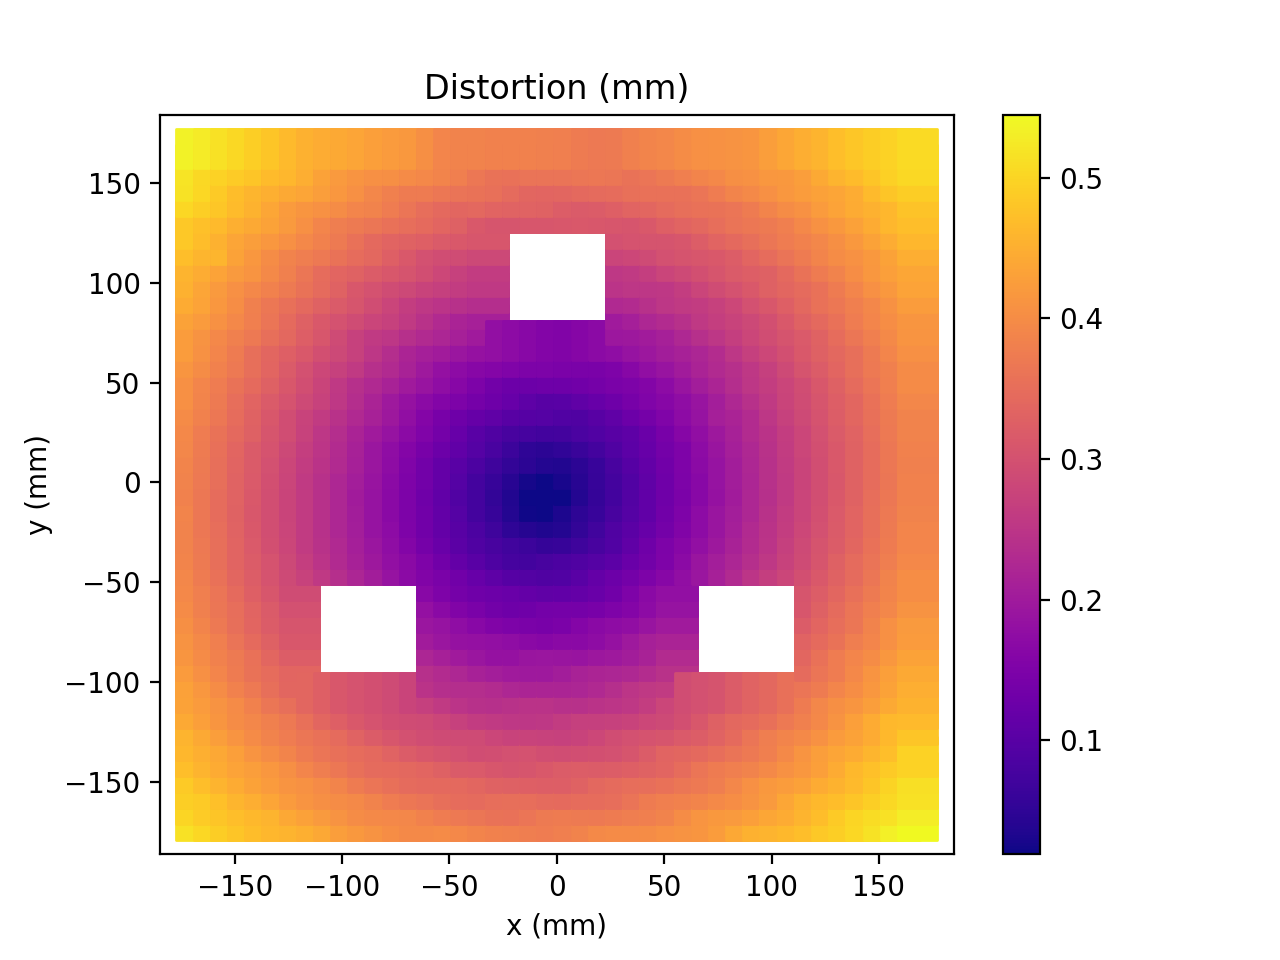

<IPython.core.display.Javascript object>


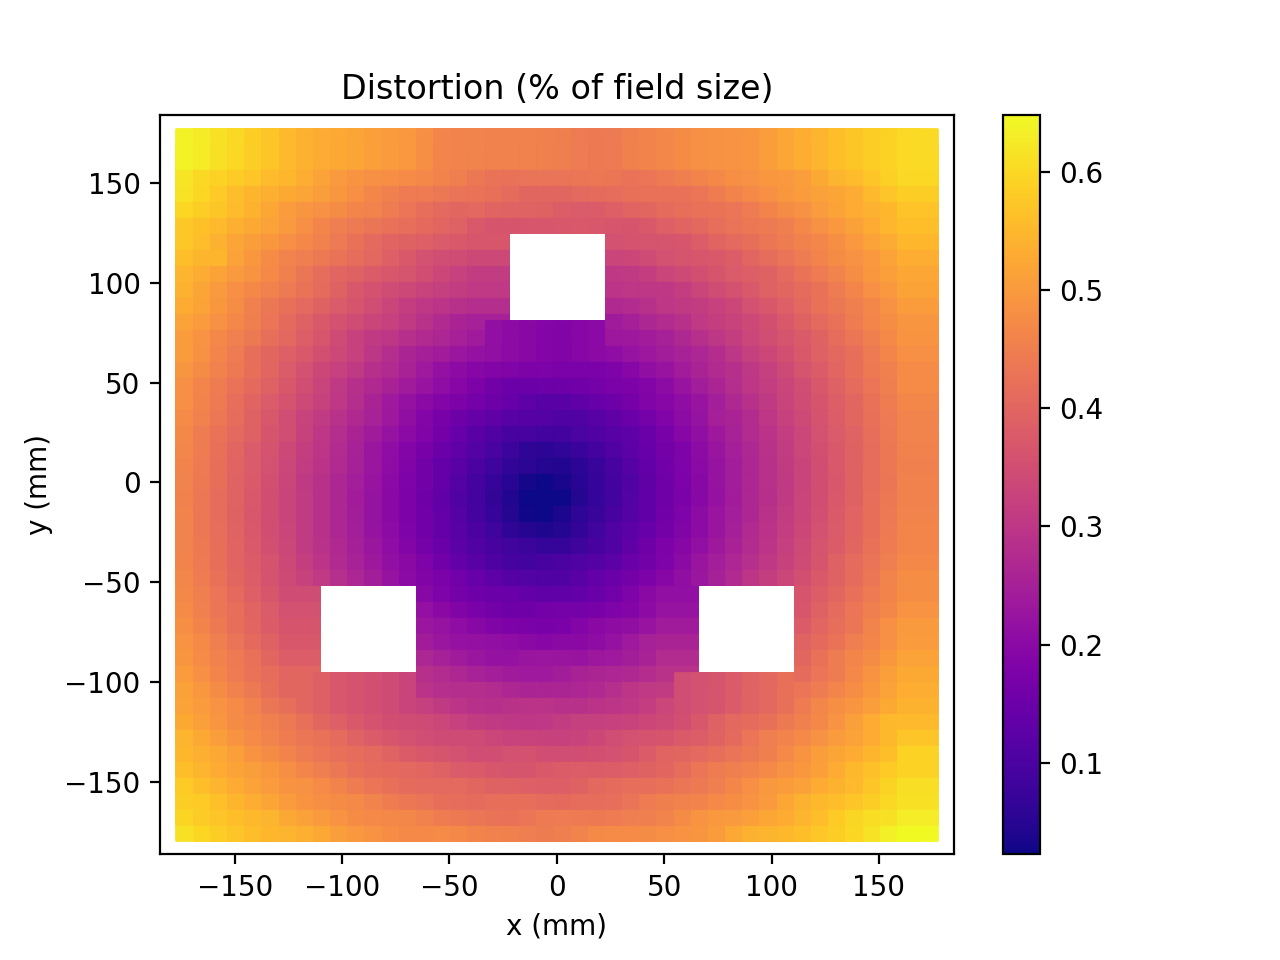

In [74]:
reload(visplot)
reload(viscalc)
c,c1,pts1,pts2,diffx,diffy=viscalc.simpleDistortion(xx,yy,xs,ys)
limit=5
visplot.plotDistortion(c,c1,pts1,pts2,diffx,diffy,fxs,fys,peaks,limit,prefix,'mm')


[ 0.  0.  0. ...,  0.  0.  0.]
